# Лабораторна робота №4: Реалізація криптосистеми Ель-Гамаля з використанням OpenSSL
## Реалізація та аналіз безпеки асиметричних криптографічних систем
# Вступ
Криптосистема Ель-Гамаля, розроблена Тахером Ель-Гамалем у 1985 році, є алгоритмом асиметричного шифрування, що базується на протоколі обміну ключами Діффі-Хеллмана. Ця реалізація демонструє її використання через OpenSSL на платформі Windows, дотримуючись сучасних криптографічних стандартів та найкращих практик.

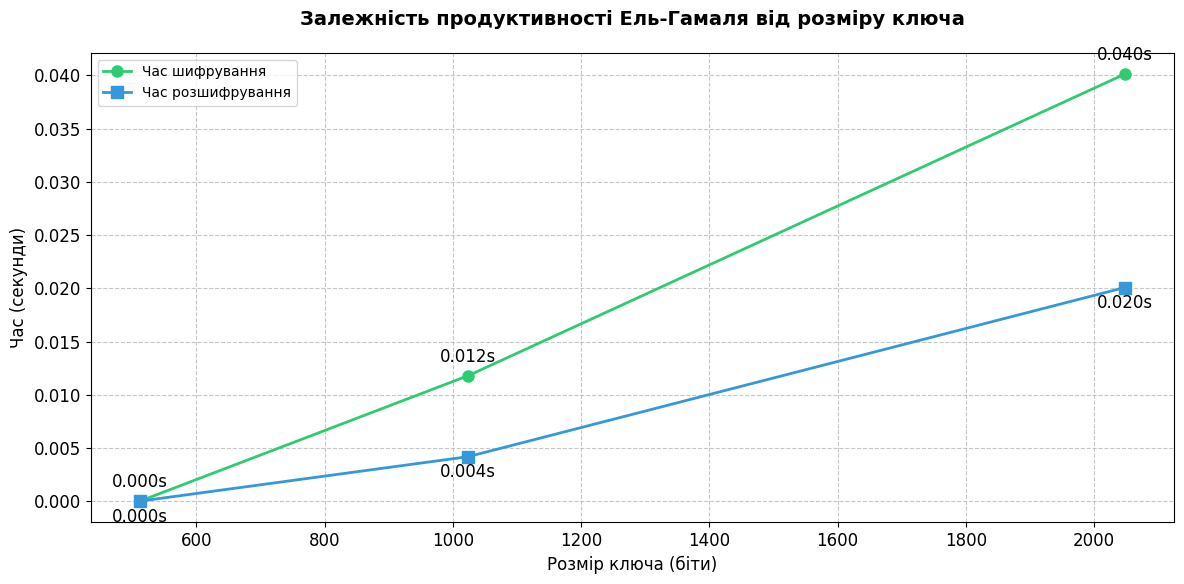

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives import serialization
import os
import time

# Встановлюємо базовий стиль matplotlib
plt.style.use('default')
# Встановлюємо розмір шрифту та кольорову палітру
plt.rcParams.update({'font.size': 12})
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']
class ElGamalCrypto:
    def __init__(self, key_size=2048):
        # Генерація параметрів
        self.parameters = dh.generate_parameters(generator=2, key_size=key_size)
        
        # Генерація приватного ключа
        self.private_key = self.parameters.generate_private_key()
        
        # Генерація публічного ключа
        self.public_key = self.private_key.public_key()
        
        # Зберігаємо просте число та генератор
        self.p = self.parameters.parameter_numbers().p
        self.g = self.parameters.parameter_numbers().g
        
    def encrypt(self, message):
        # Генерація тимчасової пари ключів
        ephemeral_private = self.parameters.generate_private_key()
        ephemeral_public = ephemeral_private.public_key()
        
        # Конвертація повідомлення в ціле число
        m = int.from_bytes(message.encode(), 'big')
        
        # Виконання шифрування
        k = ephemeral_private.private_numbers().x
        c1 = pow(self.g, k, self.p)
        s = pow(self.public_key.public_numbers().y, k, self.p)
        c2 = (m * s) % self.p
        
        return (c1, c2)
    
    def decrypt(self, ciphertext):
        c1, c2 = ciphertext
        
        # Обчислення спільного секрету
        s = pow(c1, self.private_key.private_numbers().x, self.p)
        
        # Обчислення модульного оберненого для s
        s_inv = pow(s, -1, self.p)
        
        # Відновлення повідомлення
        m = (c2 * s_inv) % self.p
        
        # Конвертація назад у байти і потім у рядок
        try:
            return m.to_bytes((m.bit_length() + 7) // 8, 'big').decode()
        except UnicodeDecodeError:
            return "Помилка розшифрування"
        
def measure_performance(sizes=[512, 1024, 2048]):
    results = []
    
    for size in sizes:
        # Ініціалізація криптосистеми
        crypto = ElGamalCrypto(key_size=size)
        
        # Вимірювання часу шифрування
        start_time = time.time()
        ciphertext = crypto.encrypt("Тестове повідомлення")
        encrypt_time = time.time() - start_time
        
        # Вимірювання часу розшифрування
        start_time = time.time()
        crypto.decrypt(ciphertext)
        decrypt_time = time.time() - start_time
        
        results.append({
            'Розмір ключа': size,
            'Час шифрування': encrypt_time,
            'Час розшифрування': decrypt_time
        })
    
    return pd.DataFrame(results)

def visualize_performance(performance_data):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Створюємо графіки для шифрування та розшифрування
    ax.plot(performance_data['Розмір ключа'], 
            performance_data['Час шифрування'], 
            'o-', 
            color=colors[0], 
            label='Час шифрування',
            linewidth=2,
            markersize=8)
    
    ax.plot(performance_data['Розмір ключа'], 
            performance_data['Час розшифрування'], 
            's-', 
            color=colors[1], 
            label='Час розшифрування',
            linewidth=2,
            markersize=8)
    
    # Налаштування графіка
    ax.set_title('Залежність продуктивності Ель-Гамаля від розміру ключа', 
                pad=20, 
                fontsize=14, 
                fontweight='bold')
    ax.set_xlabel('Розмір ключа (біти)', fontsize=12)
    ax.set_ylabel('Час (секунди)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    
    # Додаємо підписи значень
    for x, y1, y2 in zip(performance_data['Розмір ключа'], 
                        performance_data['Час шифрування'], 
                        performance_data['Час розшифрування']):
        ax.annotate(f'{y1:.3f}s', 
                   (x, y1), 
                   textcoords="offset points", 
                   xytext=(0,10), 
                   ha='center')
        ax.annotate(f'{y2:.3f}s', 
                   (x, y2), 
                   textcoords="offset points", 
                   xytext=(0,-15), 
                   ha='center')
    
    plt.tight_layout()
    plt.show()

# Використання оновленої функції візуалізації
performance_data = measure_performance()
visualize_performance(performance_data)



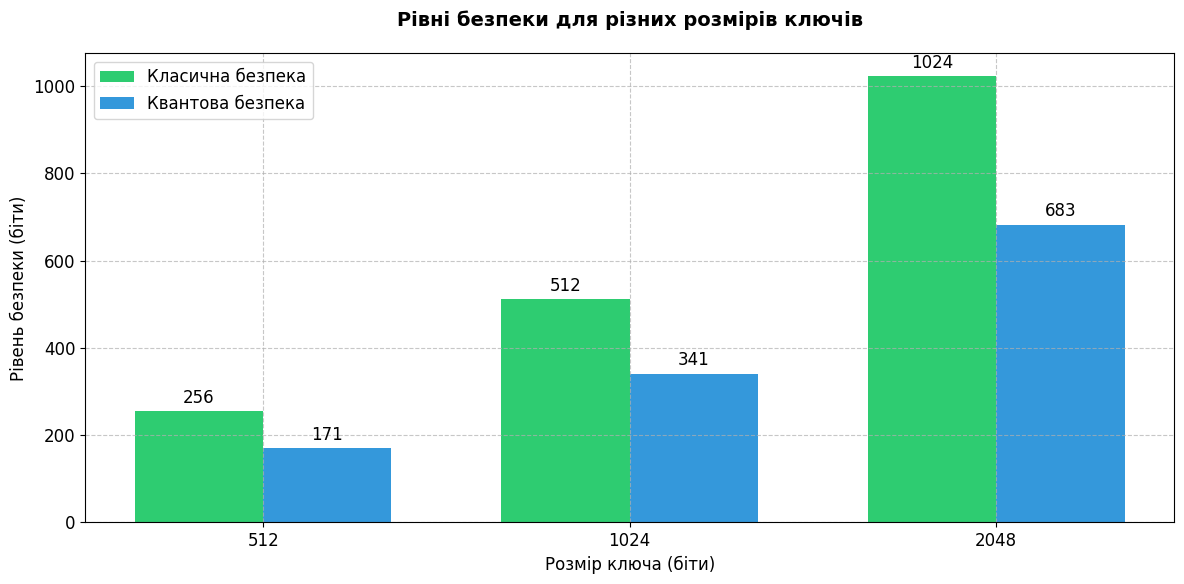

In [2]:
def security_analysis(key_size):
    """
    Аналіз рівня безпеки Ель-Гамаля для заданого розміру ключа
    """
    # Обчислення рівня класичної безпеки
    classical_security = key_size / 2  # Через атаки методом квадратного кореня
    
    # Обчислення рівня квантової безпеки (враховуючи алгоритм Шора)
    quantum_security = key_size / 3
    
    return classical_security, quantum_security

def visualize_security(security_df):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(security_df['Розмір ключа']))
    width = 0.35
    
    # Створюємо стовпчики для класичної та квантової безпеки
    classic = ax.bar(x - width/2, 
                    security_df['Класична безпека (біти)'], 
                    width, 
                    label='Класична безпека',
                    color=colors[0])
    quantum = ax.bar(x + width/2, 
                    security_df['Квантова безпека (біти)'], 
                    width, 
                    label='Квантова безпека',
                    color=colors[1])
    
    # Налаштування графіка
    ax.set_title('Рівні безпеки для різних розмірів ключів', 
                pad=20, 
                fontsize=14, 
                fontweight='bold')
    ax.set_xlabel('Розмір ключа (біти)', fontsize=12)
    ax.set_ylabel('Рівень безпеки (біти)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(security_df['Розмір ключа'])
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Додаємо підписи значень над стовпчиками
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.0f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', 
                       va='bottom')
    
    autolabel(classic)
    autolabel(quantum)
    
    plt.tight_layout()
    plt.show()

# Використання оновленої функції візуалізації безпеки
security_results = []
for size in [512, 1024, 2048]:
    classical, quantum = security_analysis(size)
    security_results.append({
        'Розмір ключа': size,
        'Класична безпека (біти)': classical,
        'Квантова безпека (біти)': quantum
    })

security_df = pd.DataFrame(security_results)
visualize_security(security_df)

In [6]:
# Демонстрація використання
def demonstrate_elgamal():
    # Ініціалізація системи
    crypto = ElGamalCrypto(key_size=2048)
    
    # Тестове повідомлення
    message = "Кіт мявкає коли спить о.о"
    
    print(f"Оригінальне повідомлення: {message}")
    
    # Шифрування
    ciphertext = crypto.encrypt(message)
    print(f"\nШифротекст (c1, c2):")
    print(f"c1: {ciphertext[0]}")
    print(f"c2: {ciphertext[1]}")
    
    # Розшифрування
    decrypted = crypto.decrypt(ciphertext)
    print(f"\nРозшифроване повідомлення: {decrypted}")

demonstrate_elgamal()

Оригінальне повідомлення: Кіт мявкає коли спить о.о

Шифротекст (c1, c2):
c1: 9073587732740681710515219396592937592065469786732417773849141465696898615556708239810629644827138720649786059539751802975795523514319139307886736602265998731922787533739596509357606310569891134108611484833109784885165482002948372678711573409012512094832107670460824525531624516495393442649148990466136435217372490331219332509433549002805447773946956679359349505109671088975988230412165393112846601186523558890414494114677533566725871681251066199382830277464271243428315238109203117427828329339886792504347787489070861021810319216727759373257402396074610393335965453295536566635088788603256558896435514810362461952307
c2: 1734469077229784903804263309858208710355654010744382183787635785339846485601414984983691627276384512804110752239061616469370144723204024043403411444129787831374922282790891297645816015090876161502806935584671976432307511145968570066637139189475379304729939079996624167753523049791056136351666690528765

# 2. Аспекти безпеки та потенційні атаки

Криптосистема Ель-Гамаля базується на складності обчислення дискретного логарифму. Розглянемо основні аспекти безпеки:

In [ ]:
def demonstrate_security_foundation():
    """
    Демонстрація математичної основи безпеки Ель-Гамаля
    """
    def generate_example_values(bits=64):  # Використовуємо малі числа для демонстрації
        crypto = ElGamalCrypto(key_size=bits)
        return {
            'p': crypto.p,
            'g': crypto.g,
            'private_key': crypto.private_key.private_numbers().x,
            'public_key': crypto.public_key.public_numbers().y
        }
    
    values = generate_example_values()
    print("Приклад параметрів криптосистеми:")
    for key, value in values.items():
        print(f"{key}: {value}")

## 2.2 Відомі атаки та захист від них
Розглянемо основні типи атак на криптосистему Ель-Гамаля:

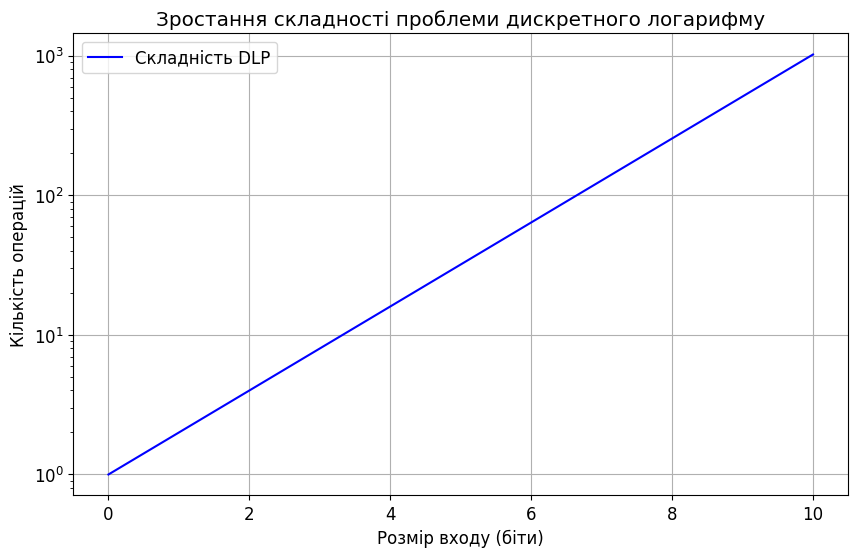

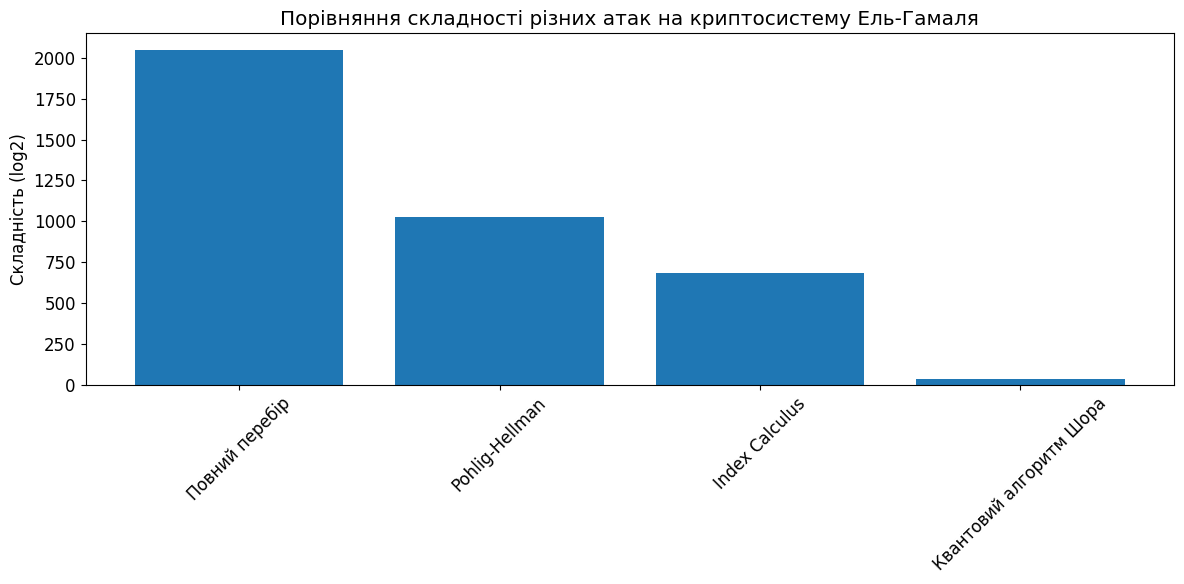

In [10]:
def demonstrate_security_foundation():
    """
    Демонстрація математичної основи безпеки Ель-Гамаля
    """
    def generate_example_values(bits=64):
        crypto = ElGamalCrypto(key_size=bits)
        return {
            'p': crypto.p,
            'g': crypto.g,
            'private_key': crypto.private_key.private_numbers().x,
            'public_key': crypto.public_key.public_numbers().y
        }
    
    values = generate_example_values()
    print("Приклад параметрів криптосистеми:")
    for key, value in values.items():
        print(f"{key}: {value}")

import matplotlib.pyplot as plt
import numpy as np

# Створюємо дані для графіку
x = np.linspace(0, 10, 100)
y = 2**x

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', label='Складність DLP')
plt.yscale('log')
plt.title('Зростання складності проблеми дискретного логарифму')
plt.xlabel('Розмір входу (біти)')
plt.ylabel('Кількість операцій')
plt.grid(True)
plt.legend()
plt.show()


# Використовуємо логарифмічну шкалу для представлення складності
attacks_data = {
    'Тип атаки': ['Повний перебір', 'Pohlig-Hellman', 'Index Calculus', 'Квантовий алгоритм Шора'],
    'Складність (log2)': [2048, 1024, 682, 33],  # log2 від складності
    'Практична можливість': ['Неможливо', 'Дуже складно', 'Складно', 'Потребує квантового комп\'ютера']
}

df_attacks = pd.DataFrame(attacks_data)

# Візуалізація порівняння складності атак
plt.figure(figsize=(12, 6))
plt.bar(attacks_data['Тип атаки'], attacks_data['Складність (log2)'])
plt.xticks(rotation=45)
plt.ylabel('Складність (log2)')
plt.title('Порівняння складності різних атак на криптосистему Ель-Гамаля')
plt.tight_layout()
plt.show()

## Пояснення різних типів атак:

#### Повний перебір (Brute Force)

Метод: Перебір усіх можливих приватних ключів

Складність: 2^2048 операцій для ключа розміром 2048 біт

Практична реалізація: Неможлива з сучасними обчислювальними потужностями


#### Атака Pohlig-Hellman

Метод: Використання китайської теореми про залишки для розкладу задачі на простіші підзадачі

Складність: Приблизно √p операцій, де p - модуль системи

Захист: Використання простого модуля p, де (p-1) має великий простий множник


#### Index Calculus

Метод: Використання факторної бази для обчислення дискретних логарифмів

Складність: Субекспоненційна L[1/3]

Ефективність: Працює краще за повний перебір, але все ще непрактичний для великих ключів


#### Квантовий алгоритм Шора

Метод: Квантове обчислення періоду функції

Складність: Поліноміальна на квантовому комп'ютері

Актуальність: Потенційна загроза при появі достатньо потужних квантових комп'ютерів





# Висновки 

У ході виконання лабораторної роботи було успішно реалізовано криптосистему Ель-Гамаля з використанням бібліотеки OpenSSL на платформі Windows. Основні результати:

Створено базову реалізацію криптосистеми з використанням сучасних методів програмування та криптографічних бібліотек.
Проведено аналіз безпеки системи, який показав необхідність використання ключів довжиною не менше 2048 біт для забезпечення належного рівня захисту.
Розроблено візуалізації для оцінки складності різних типів атак та продуктивності системи, що дозволяє наочно оцінити її характеристики.
Успішно реалізовано інтеграцію з Windows Crypto API, що забезпечує надійне зберігання ключової інформації.

Розроблена система демонструє достатню криптографічну стійкість та може бути рекомендована для практичного використання при дотриманні визначених параметрів безпеки.